# Two Object CNN Model 

## Libraries

In [1]:
import tensorflow as tf
# from tensorflow.keras import layers
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.optim as optim
import torchvision.utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torchvision import datasets, transforms
from types import SimpleNamespace
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from torchvision.transforms import functional as FF
import random
from torchvision import datasets, transforms
import torch
from sklearn.model_selection import train_test_split
import os
from argparse import Namespace as SimpleNamespace


## Functions

In [2]:
# Function to calculate the output size after a convolution or pooling layer
def conv2d_output_size(input_size, kernel_size, padding=0, stride=1):
    output_size = (input_size - kernel_size + 2*padding) // stride + 1
    return output_size

# Function to calculate the size after a sequence of convolution and pooling
def calculate_conv_output_size(input_size, *layers):
    size = input_size
    for layer in layers:
        if isinstance(layer, nn.Conv2d):
            size = conv2d_output_size(size, layer.kernel_size[0], padding=layer.padding[0], stride=layer.stride[0])
        elif isinstance(layer, nn.MaxPool2d):
            size = conv2d_output_size(size, layer.kernel_size, padding=layer.padding, stride=layer.stride)
    return size

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}')

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        print(f'Validation Loss: {val_loss / len(val_loader)}')

In [3]:
def number_to_binary_vector(number):
    binary_vector = [0] * 10
    binary_vector[number] = 1
    return binary_vector

def spatial_label_to_vector(label):
    binary_vector = [0] * 4
    if label == "left":
        binary_vector[0] = 1
    elif label == "above":
        binary_vector[1] = 1
    elif label == "below left":
        binary_vector[2] = 1
    if label == "below right":
        binary_vector[3] = 1
    return binary_vector

def outcomeVector(label_1, label_2, spatial_label):
    if spatial_label == "above right":
        label_1, label_2 = label_2, label_1
        spatial_label = "below left"
    elif spatial_label == "above left":
        label_1, label_2 = label_2, label_1
        spatial_label = "below right"
    vector1 = number_to_binary_vector(label_1)
    vector2 = number_to_binary_vector(label_2)
    vector12 = np.concatenate((vector1, vector2))
    vector3 = spatial_label_to_vector(spatial_label)
    vector = np.concatenate((vector12, vector3))
    return vector

def spatial_relation_labels(x1,y1,x2,y2):
    
    if y1 == y2:
        label = "left"
    elif x1 == x2:
        label = "above"
    elif x1< x2 and y1 < y2:
        label = "above left"
    elif x1 > x2 and y1 < y2:
        label = "above right"
    else:
        label = "below left"
    return label

In [4]:
def create_samples_with_non_overlapping_images_and_vectors(train_loader, num_samples=100):
    # creates a number of images containing three random items from FashionMNIST dataset with two vectors of 10 binary values, 
    # which encode names of the two items in the image and their spatial relation, and the name of the spatial relation between
    # the two items 
    samples = []
    for _ in range(num_samples):
        background = torch.zeros(1, 56, 56)

        idx1, idx2 = np.random.choice(len(train_loader.dataset), 2, replace=False)
        img1, label_1 = train_loader.dataset[idx1]
        img2, label_2 = train_loader.dataset[idx2]
        
        while True:
            if label_1 == label_2:
                idx2 = np.random.choice(len(train_loader.dataset), 1, replace=False)[0]
                img2, label_2 = train_loader.dataset[idx2]
                continue
            else:
                break

        img1 = (img1 - img1.min()) / (img1.max() - img1.min())
        img2 = (img2 - img2.min()) / (img2.max() - img2.min())
        
        a = np.random.randint(-27, 28)

        if a >= 0:
            x1 = a
            y1 = 0
        else:
            x1 = 0
            y1 = abs(a)
        
        if x1 > 0 and y1 == 0:
            y2 = 27
            x2 = np.random.randint(0, 28)
        elif x1 == 0 and y1 == 0:
            b = np.random.randint(0, 56)
            if b < 28:
                x2 = b
                y2 = 27
            else:
                x2 = 27
                y2 = 55 - b
        else:
            x2 = 27
            y2 = np.random.randint(0, 28)
            
        background[:, y1:y1+28, x1:x1+28] = img1
        background[:, y2:y2+28, x2:x2+28] = img2
        spatial_label = spatial_relation_labels(x1,y1,x2,y2)
        vector = outcomeVector(label_1, label_2, spatial_label)

        samples.append((background, vector))

    return samples

In [5]:
def transform_loader(data_loader, num_samples=None):
    if num_samples is None:
        num_samples = len(data_loader.dataset)
    
    transformed_data = create_samples_with_non_overlapping_images_and_vectors(data_loader, num_samples)
    
    return transformed_data

## Loading Data

In [26]:
from torchvision import datasets, transforms
import torch
from sklearn.model_selection import train_test_split
import os
from argparse import Namespace as SimpleNamespace

args = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=1, lr=0.01, momentum=0.5, seed=1, log_interval=100)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Transformation for the dataset
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# FashionMNIST training and test datasets
full_train_dataset = datasets.FashionMNIST(
    os.path.join('.','..','data'), 
    train=True, 
    download=True, 
    transform=transformation
)
full_test_dataset = datasets.FashionMNIST(
    os.path.join('.','..','data'), 
    train=False, 
    download=True, 
    transform=transformation
)

full_dataset = torch.utils.data.ConcatDataset([full_train_dataset, full_test_dataset])
torch.manual_seed(args.seed)

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(0.64 * total_size)
val_size = int(0.16 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
test_dataset, val_test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [val_size, test_size])

# D loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=True, **kwargs)

# Check proportions
print(f'Train data is {100 * len(test_dataset) / total_size}% of the dataset')
print(f'Val data is {100 * len(val_dataset) / total_size}% of the dataset')
print(f'Test data is {100 * len(test_dataset) / total_size}% of the dataset')


Train data is 64.0% of the dataset
Val data is 16.0% of the dataset
Test data is 20.0% of the dataset


# Preprocessing Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.28789353..1.9107434].


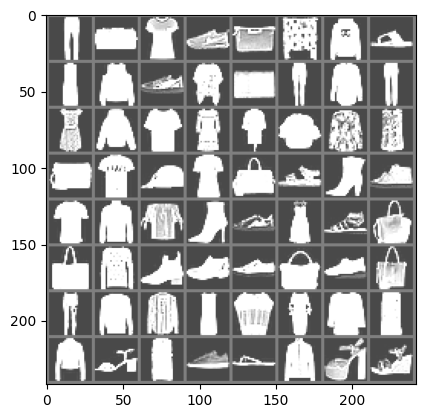

Labels:  [1, 8, 0, 7, 8, 6, 2, 5, 6, 2, 7, 6, 8, 1, 6, 1, 3, 4, 0, 3, 4, 8, 6, 0, 8, 0, 8, 0, 8, 5, 9, 7, 0, 4, 6, 9, 7, 3, 5, 8, 8, 2, 9, 9, 7, 8, 7, 8, 1, 2, 6, 3, 6, 3, 0, 0, 4, 5, 0, 7, 5, 4, 5, 5]


In [7]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter) 

imshow(torchvision.utils.make_grid(images))
print('Labels: ', labels.tolist())


In [27]:
train_data = transform_loader(train_loader)
val_data = transform_loader(val_loader)
test_data = transform_loader(test_loader)

## Examples

Example nr 1: 
Input: 


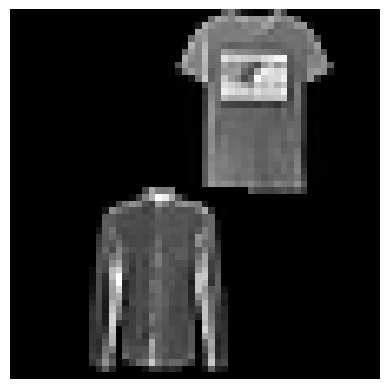

Output:  [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0] 

Example nr 2: 
Input: 


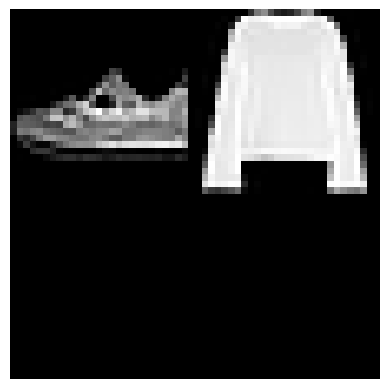

Output:  [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0] 

Example nr 3: 
Input: 


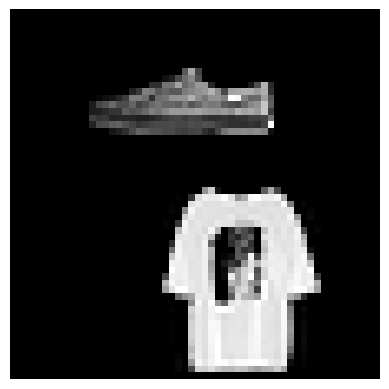

Output:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1] 



In [9]:
for i in range(3):
    img, vector = train_data[i]
    print(f"Example nr {i+1}: ")
    print("Input: ")
    plt.imshow(img.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()
    print("Output: ", vector,"\n")   

Example nr 1: 
Input: 


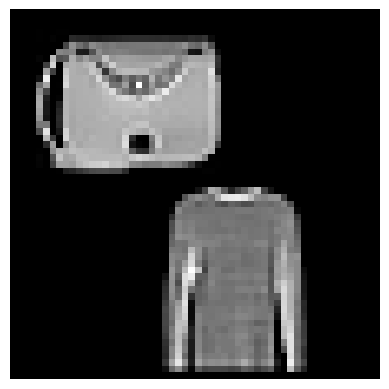

Output:  [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1] 

Example nr 2: 
Input: 


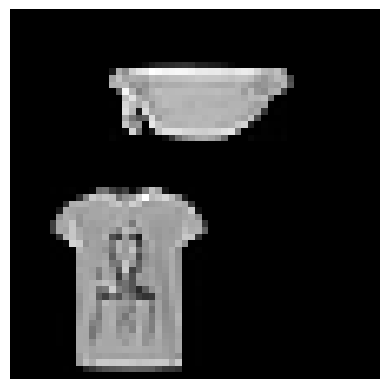

Output:  [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0] 

Example nr 3: 
Input: 


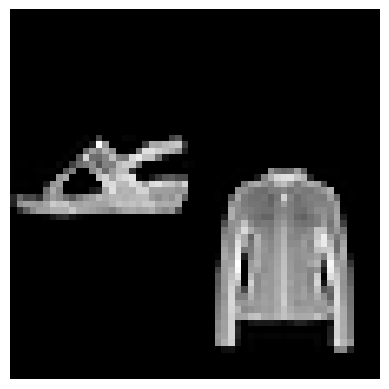

Output:  [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1] 

Example nr 4: 
Input: 


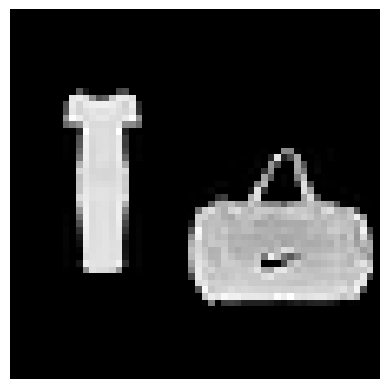

Output:  [0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1] 

Example nr 5: 
Input: 


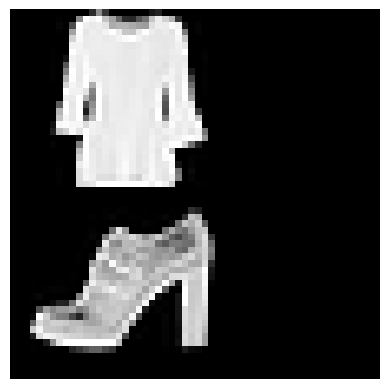

Output:  [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0] 



In [10]:
samples = create_samples_with_non_overlapping_images_and_vectors(test_loader,5)

for i in range(5):
    img, vector = samples[i]
    print(f"Example nr {i+1}: ")
    print("Input: ")
    plt.imshow(img.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()
    print("Output: ", vector,"\n")    

# THE TWO OBJECT MODEL 

## Our Hiperparameters should look like this:

In [11]:
# number of Filters: This determines the number of output channels in each convolutional layer (i.e., the depth of the feature maps). Common choices are 32, 64, and 128.
# Kernel Size: The size of the filter that will convolve around the input volume. Common sizes are 3x3, 5x5, and 11x11.
# Optimizer: This is the algorithm used to update the weights of the network. Adam and Stochastic Gradient Descent (SGD) are two commonly used optimizers.
# Learning Rate (LR): This is a hyperparameter that controls the amount by which the weights are updated during training. Common starting values are 0.01, 0.001, and 0.0001.
# LR Decay: Whether to use learning rate decay, which reduces the learning rate over time.
# Batch Size: The number of training samples used in one iteration. Options here include 1 (stochastic), 32, 64, or using the full dataset (batch gradient descent).
# Dropout: A regularization technique that involves randomly setting a fraction of input units to 0 at each update during training to prevent overfitting. Common values are 0.2, 0.3, 0.4, and 0.5.

import pandas as pd

# Define the hyperparameters and their corresponding options and search methods
hyperparameters = {
    "Hyperparameter": [
        "Number of filters",
        "Kernel size",
        "Optimiser",
        "Learning rate",
        "LR Decay",
        "Batch size",
        "Dropout"
    ],
    "Options": [
        "32, 64, 128",
        "3 x 3, 5 x 5, 11 x 11",
        "Adam, SGD",
        "0.01, 0.001, 0.0001",
        "Yes, No",
        "1, 32, 64, full",
        "0.2, 0.3, 0.4, 0.5"
    ],
    "Search": [
        "H",
        "M",
        "H",
        "M",
        "M",
        "M",
        "M"
    ]
}

# Create and print a DataFrame
df_hyperparameters = pd.DataFrame(hyperparameters)
print(df_hyperparameters.to_string(index=False))

   Hyperparameter               Options Search
Number of filters           32, 64, 128      H
      Kernel size 3 x 3, 5 x 5, 11 x 11      M
        Optimiser             Adam, SGD      H
    Learning rate   0.01, 0.001, 0.0001      M
         LR Decay               Yes, No      M
       Batch size       1, 32, 64, full      M
          Dropout    0.2, 0.3, 0.4, 0.5      M


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatialRelationCNN(nn.Module):
    def __init__(self):
        super(SpatialRelationCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=11, padding=5)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7*7*128, 512)
        self.fc_output = nn.Linear(512, 24)  

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x_flattened = x.view(x.size(0), -1)
        fc_out = F.relu(self.fc1(x_flattened))
        x_output = self.fc_output(fc_out)
        
        return x_output


#### Trening standardowej sieci

In [13]:
train_images = torch.stack([item[0] for item in train_data])  
train_vectors = torch.stack([torch.tensor(item[1]) for item in train_data])  

test_dataset = TensorDataset(train_images, train_vectors)

batch_size = 64
train_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

num_epochs = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.BCEWithLogitsLoss()
model = SpatialRelationCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    model.train()  
    total_loss = 0
    for inputs, labels in train_loader:  
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_data)}')

    if (epoch + 1) % 10 == 0:
        model_path = f'normal_cnn_epoch_{epoch+1}.pth'
        torch.save(model.state_dict(), model_path)


Epoch 1/50, Loss: 0.002522322523706992
Epoch 2/50, Loss: 0.0015358453313820063
Epoch 3/50, Loss: 0.0012231860052062465
Epoch 4/50, Loss: 0.001008520064642653
Epoch 5/50, Loss: 0.0008428889409905034
Epoch 6/50, Loss: 0.0006989185892494528
Epoch 7/50, Loss: 0.0005518309651025837
Epoch 8/50, Loss: 0.0004201144992839545
Epoch 9/50, Loss: 0.0003003439835655237
Epoch 10/50, Loss: 0.0002018676720867266
Epoch 11/50, Loss: 0.00015022890805474682
Epoch 12/50, Loss: 0.00012207034244056557
Epoch 13/50, Loss: 9.173390772567862e-05
Epoch 14/50, Loss: 9.418948457615832e-05
Epoch 15/50, Loss: 8.781410720725295e-05
Epoch 16/50, Loss: 6.721711401886361e-05
Epoch 17/50, Loss: 6.998202756156908e-05
Epoch 18/50, Loss: 6.859976465810697e-05
Epoch 19/50, Loss: 5.519716710945691e-05
Epoch 20/50, Loss: 4.646069538044425e-05
Epoch 21/50, Loss: 6.072955657730615e-05
Epoch 22/50, Loss: 5.06015090062257e-05
Epoch 23/50, Loss: 4.373626759128716e-05
Epoch 24/50, Loss: 4.605746572289198e-05
Epoch 25/50, Loss: 4.14984

KeyboardInterrupt: 

In [15]:
for epoch in range(31,50):
    model.train()  
    total_loss = 0
    for inputs, labels in train_loader:  
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_data)}')

    if (epoch + 1) % 10 == 0:
        model_path = f'normal_cnn_epoch_{epoch+1}.pth'
        torch.save(model.state_dict(), model_path)

Epoch 32/50, Loss: 3.1188100411928386e-05
Epoch 33/50, Loss: 3.834013898670362e-05
Epoch 34/50, Loss: 2.555579018700119e-05
Epoch 35/50, Loss: 2.9465991221887376e-05
Epoch 36/50, Loss: 3.064981467153822e-05
Epoch 37/50, Loss: 1.956479284753446e-05
Epoch 38/50, Loss: 2.8890846544494968e-05
Epoch 39/50, Loss: 3.057739465335528e-05
Epoch 40/50, Loss: 1.952917226999164e-05
Epoch 41/50, Loss: 2.5633431933686423e-05
Epoch 42/50, Loss: 2.521303300487229e-05
Epoch 43/50, Loss: 2.6130564385746473e-05
Epoch 44/50, Loss: 2.5490118412635964e-05
Epoch 45/50, Loss: 1.8709531515871243e-05
Epoch 46/50, Loss: 2.4624844778194138e-05
Epoch 47/50, Loss: 1.946636567020781e-05
Epoch 48/50, Loss: 1.9323760711082675e-05
Epoch 49/50, Loss: 2.1954170368790724e-05
Epoch 50/50, Loss: 1.660064792494e-05


In [16]:
for epoch in range(49,100):
    model.train()  
    total_loss = 0
    for inputs, labels in train_loader:  
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_data)}')

    if (epoch + 1) % 10 == 0:
        model_path = f'normal_cnn_epoch_{epoch+1}.pth'
        torch.save(model.state_dict(), model_path)

Epoch 50/50, Loss: 2.3213171703438156e-05
Epoch 51/50, Loss: 1.0469488052809847e-05
Epoch 52/50, Loss: 3.0423449609660988e-05
Epoch 53/50, Loss: 2.1047829064489827e-05
Epoch 54/50, Loss: 9.220613570961283e-06
Epoch 55/50, Loss: 2.814833734883036e-05
Epoch 56/50, Loss: 1.2135752235177424e-05
Epoch 57/50, Loss: 1.9817179713328413e-05
Epoch 58/50, Loss: 1.7225237324964838e-05
Epoch 59/50, Loss: 2.168108665437834e-05
Epoch 60/50, Loss: 1.8398805546553377e-05
Epoch 61/50, Loss: 1.6322910416793742e-05
Epoch 62/50, Loss: 1.6503231478160225e-05
Epoch 63/50, Loss: 1.9416785733541126e-05
Epoch 64/50, Loss: 1.0363794370279932e-05
Epoch 65/50, Loss: 1.4424039283704408e-05
Epoch 66/50, Loss: 1.5241483897686488e-05
Epoch 67/50, Loss: 1.4105624160509122e-05
Epoch 68/50, Loss: 1.9915643910439127e-05
Epoch 69/50, Loss: 1.8480614874393706e-05
Epoch 70/50, Loss: 1.553695983726503e-05
Epoch 71/50, Loss: 9.58817293360527e-06
Epoch 72/50, Loss: 1.6539909063748582e-05
Epoch 73/50, Loss: 1.566235846665265e-05

#### Wyniki dla standardowego modelu - 100 epok

In [28]:
def calculate_accuracy_standard(model, loader, device):
    model.eval()  
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predicted == labels).all(dim=1).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
standard_model = SpatialRelationCNN().to(device)
standard_model.load_state_dict(torch.load('normal_cnn_epoch_100.pth'))

test_images = torch.stack([item[0] for item in test_data])  
test_vectors = torch.stack([torch.tensor(item[1]) for item in test_data])  
test_dataset = TensorDataset(test_images, test_vectors)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

test_accuracy = calculate_accuracy_standard(standard_model, test_loader, device)
print(f'Accuracy on the test set Standard: {test_accuracy:.4f}')

Accuracy on the test set Standard: 0.6822


### RNA

In [31]:
def add_uniform_noise(images, noise_level=0.1, num_noisy_pixels=500):
    noisy_images = images.clone()
    for img in noisy_images:
        c, h, w = img.shape
        total_pixels = h * w
        random_indices = torch.randperm(total_pixels)[:num_noisy_pixels]
        noise = torch.rand(num_noisy_pixels) * noise_level
        img.view(-1)[random_indices] += noise
    return noisy_images.clamp(0, 1)

In [32]:
class FiLM(nn.Module):
    def forward(self, x, gamma, beta):
        gamma = gamma.view(x.size(0), x.size(1), 1, 1).expand_as(x)
        beta = beta.view(x.size(0), x.size(1), 1, 1).expand_as(x)
        return gamma * x + beta

class SpatialRelationCNN(nn.Module):
    def __init__(self, num_film_layers=3):
        super(SpatialRelationCNN, self).__init__()
        self.num_film_layers = num_film_layers

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.film1 = FiLM()
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.film2 = FiLM()

        self.conv3 = nn.Conv2d(64, 128, kernel_size=11, padding=5)
        self.bn3 = nn.BatchNorm2d(128)
        self.film3 = FiLM()
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(7*7*128, 512)
        self.fc_output = nn.Linear(512, 24)  

    def forward(self, x, gammas=None, betas=None):
        # FiLM layer is applied after every block with convolutional layer
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        if gammas is not None and betas is not None:
            gamma1, beta1 = gammas[:, 0, :32], betas[:, 0, :32]
            x = self.film1(x, gamma1, beta1)
        
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        if gammas is not None and betas is not None:
            gamma2, beta2 = gammas[:, 1, :64], betas[:, 1, :64]
            x = self.film2(x, gamma2, beta2)

        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        if gammas is not None and betas is not None:
            gamma3, beta3 = gammas[:, 2, :128], betas[:, 2, :128]
            x = self.film3(x, gamma3, beta3)

        x_flattened = x.view(x.size(0), -1)

        fc_out = F.relu(self.fc1(x_flattened))
        x_output = self.fc_output(fc_out)
        
        return x_output

class ControllerNetwork(nn.Module):
    def __init__(self, input_dim, film_dim, num_film_layers):
        super(ControllerNetwork, self).__init__()
        self.num_film_layers = num_film_layers 
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc_gamma = nn.Linear(128, film_dim * num_film_layers)
        self.fc_beta = nn.Linear(128, film_dim * num_film_layers)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        gammas = self.fc_gamma(x).view(x.size(0), self.num_film_layers, -1)
        betas = self.fc_beta(x).view(x.size(0), self.num_film_layers, -1)
        return gammas, betas

class AdaptableSpatialRelationCNN(nn.Module):
    def __init__(self):
        super(AdaptableSpatialRelationCNN, self).__init__()
        self.main_network = SpatialRelationCNN(num_film_layers=3)
        self.controller_network = ControllerNetwork(input_dim=48, film_dim=128, num_film_layers=3)

    def forward(self, x, adaptation_signal):
        prediction = self.main_network(x)  
        combined_input = torch.cat((prediction, adaptation_signal), dim=1)
        gammas, betas = self.controller_network(combined_input)
        adjusted_prediction = self.main_network(x, gammas, betas) 
        return adjusted_prediction


In [33]:
def calculate_entropy(probs):
    dist = Categorical(probs)
    entropy = dist.entropy()
    return entropy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AdaptableSpatialRelationCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_images = torch.stack([item[0] for item in train_data])
train_vectors = torch.stack([torch.tensor(item[1]) for item in train_data])

batch_size = 64
num_epochs = 50

In [ ]:
#trening w innym pliku
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    adaptation_signals = []

    for inputs, labels in DataLoader(TensorDataset(train_images, train_vectors), batch_size=batch_size, shuffle=True):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model.main_network(inputs)  
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        probs = torch.sigmoid(outputs).detach().cpu()
        entropy = calculate_entropy(probs)
        adaptation_signals.append(entropy)

    adaptation_signals = torch.cat(adaptation_signals).to(device)
    adaptation_signals = adaptation_signals.unsqueeze(1).repeat(1, 24)
    train_dataset = TensorDataset(train_images, train_vectors, adaptation_signals)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for inputs, labels, adaptation_signal in train_loader:
        inputs, labels, adaptation_signal = inputs.to(device), labels.to(device), adaptation_signal.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, adaptation_signal)  
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_data)}')
    
    if (epoch + 1) % 10 == 0:
        model_path = f'rna_cnn_epoch_{epoch+1}.pth'
        torch.save(model.state_dict(), model_path)

### Noise level comparison

In [34]:
def plot_accuracy_comparison(accuracy_scores1, accuracy_scores2, noise_levels, label1='RNA', label2='Standard', label3=', 100 pixels'):
    plt.figure(figsize=(10, 6))
    plt.plot(noise_levels, accuracy_scores1, marker='o', linestyle='-', color='b', label=label1)
    plt.plot(noise_levels, accuracy_scores2, marker='o', linestyle='-', color='r', label=label2)
    plt.xlabel('Noise Level')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Noise Level for Two Models' + label3)
    plt.grid(True)
    plt.xticks(noise_levels)
    plt.ylim(0, 1)  
    plt.legend()
    plt.show()

In [35]:
# loading RNA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AdaptableSpatialRelationCNN().to(device)
model.load_state_dict(torch.load('rna_cnn_epoch_50.pth'))

def calculate_accuracy(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model.main_network(inputs)
            probs = torch.sigmoid(outputs).cpu()
            entropy = calculate_entropy(probs).unsqueeze(1).repeat(1, 24).to(device)

            adjusted_outputs = model(inputs, entropy)
            predicted = (torch.sigmoid(adjusted_outputs) > 0.5).float()
            correct += (predicted == labels).all(dim=1).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy

test_images = torch.stack([item[0] for item in test_data])
test_vectors = torch.stack([torch.tensor(item[1]) for item in test_data])

In [44]:
# loading standard model
standard_model = SpatialRelationCNN().to(device)
standard_model.load_state_dict(torch.load('normal_cnn_epoch_50.pth'))

def calculate_accuracy_standard(model, loader, device):
    correct = 0
    total = 0
    
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            predictions = torch.sigmoid(outputs) > 0.5
            correct += (predictions == labels).all(dim=1).sum().item()
            total += labels.size(0)
    
    accuracy = correct / total
    return accuracy

In [37]:
noise_levels = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3] # noise levels for comparison

calculations for RNA

In [38]:
accuracy_scores = []

for noise_level in noise_levels:
    noisy_test_images = add_uniform_noise(test_images, noise_level=noise_level, num_noisy_pixels=100)
    val_dataset = TensorDataset(noisy_test_images, test_vectors)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    accuracy = calculate_accuracy(model, val_loader, device)
    print(f'Accuracy on the test set with noise level {noise_level}: {accuracy:.4f}')
    accuracy_scores.append(accuracy)

Accuracy on the test set with noise level 0.0: 0.6824
Accuracy on the test set with noise level 0.05: 0.6853
Accuracy on the test set with noise level 0.1: 0.6847
Accuracy on the test set with noise level 0.15: 0.6832
Accuracy on the test set with noise level 0.2: 0.6786
Accuracy on the test set with noise level 0.25: 0.6674
Accuracy on the test set with noise level 0.3: 0.6524


In [49]:
accuracy_scores_standard = []
for noise_level in noise_levels:
    noisy_test_images = add_uniform_noise(test_images, noise_level=noise_level, num_noisy_pixels=100)
    val_dataset = TensorDataset(noisy_test_images, test_vectors)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    accuracy = calculate_accuracy_standard(standard_model, val_loader, device)
    print(f'Accuracy on the test set with noise level {noise_level}: {accuracy:.4f}')
    accuracy_scores_standard.append(accuracy)

Accuracy on the test set with noise level 0.0: 0.6798
Accuracy on the test set with noise level 0.05: 0.6791
Accuracy on the test set with noise level 0.1: 0.6717
Accuracy on the test set with noise level 0.15: 0.6600
Accuracy on the test set with noise level 0.2: 0.6424
Accuracy on the test set with noise level 0.25: 0.6147
Accuracy on the test set with noise level 0.3: 0.5761


Example nr 5: 
Input: 


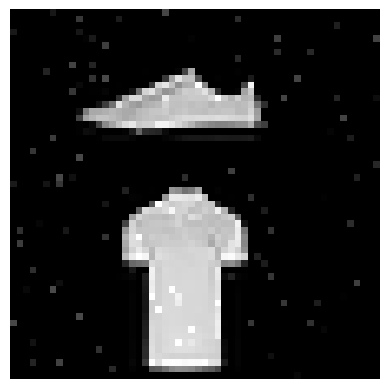

In [65]:
# przykładowy image z noisem 0.3
img = noisy_test_images[3]
print(f"Example nr {i+1}: ")
print("Input: ")
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.axis('off')
plt.show()

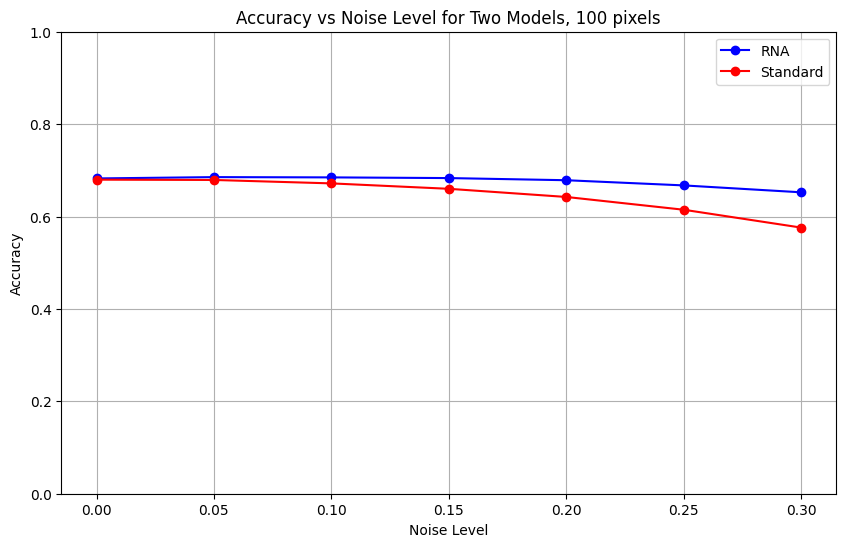

In [50]:
plot_accuracy_comparison(accuracy_scores, accuracy_scores_standard, noise_levels, label1='RNA', label2='Standard')

### Porównanie accuracy na standardowych obrazkach

In [51]:
test_images = torch.stack([item[0] for item in test_data])
test_vectors = torch.stack([torch.tensor(item[1]) for item in test_data])

test_dataset = TensorDataset(test_images, test_vectors)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [52]:
accuracy = calculate_accuracy(model, test_loader, device)
print(f'Accuracy on the test set RNA: {accuracy:.4f}')

Accuracy on the test set RNA: 0.6824


In [53]:
test_accuracy = calculate_accuracy_standard(standard_model, test_loader, device)
print(f'Accuracy on the test set Standard: {test_accuracy:.4f}')

Accuracy on the test set Standard: 0.6798


### Porównanie accuracy na różnych rozmiarach obrazków

In [54]:
def create_samples_with_scaled_images_and_vectors(loader, low_bound, high_bound, num_samples=100):
    samples = []

    for _ in range(num_samples):
        background = torch.zeros(1, 56, 56)

        idx1, idx2 = np.random.choice(len(loader.dataset), 2, replace=False)
        img1, label_1 = loader.dataset[idx1]
        img2, label_2 = loader.dataset[idx2]

        while label_1 == label_2:
            idx2 = np.random.choice(len(loader.dataset), 1, replace=False)[0]
            img2, label_2 = loader.dataset[idx2]

        if low_bound == 1 and high_bound == 1:
            scaled_img1 = img1
            scaled_img2 = img2
        else:
            scale1 = np.random.uniform(low_bound, high_bound)
            scale2 = np.random.uniform(low_bound, high_bound)
            scaled_img1 = FF.resize(img1, [int(28 * scale1), int(28 * scale1)])
            scaled_img2 = FF.resize(img2, [int(28 * scale2), int(28 * scale2)])
            scaled_img1 = (scaled_img1 - scaled_img1.min()) / (scaled_img1.max() - scaled_img1.min())
            scaled_img2 = (scaled_img2 - scaled_img2.min()) / (scaled_img2.max() - scaled_img2.min())

        max_attempts = 100
        for attempt in range(max_attempts):
            x1, y1 = np.random.randint(0, 56 - scaled_img1.shape[1]), np.random.randint(0, 56 - scaled_img1.shape[2])
            x2, y2 = np.random.randint(0, 56 - scaled_img2.shape[1]), np.random.randint(0, 56 - scaled_img2.shape[2])

            if not (x1 < x2 + scaled_img2.shape[1] and x1 + scaled_img1.shape[1] > x2 and y1 < y2 + scaled_img2.shape[2] and y1 + scaled_img1.shape[2] > y2):
                break
        else:
            continue

        background[:, y1:y1 + scaled_img1.shape[1], x1:x1 + scaled_img1.shape[2]] = scaled_img1
        background[:, y2:y2 + scaled_img2.shape[1], x2:x2 + scaled_img2.shape[2]] = scaled_img2

        spatial_label = spatial_relation_labels(x1, y1, x2, y2)
        vector = outcomeVector(label_1, label_2, spatial_label)

        samples.append((background, vector))

    if not samples:
        print(f"Warning: No samples generated for {low_bound} - {high_bound}. Check the scale range.")
    
    return samples


def visualize_samples(dataset, num_samples=50):
    for i in range(num_samples):
        img, vector = dataset[i]
        print(f"Sample {i+1}:")
        print("Input Image:")
        plt.imshow(img.squeeze(), cmap='gray')
        plt.axis('off')
        plt.show()
        print("Output Vector:", vector, "\n")

In [55]:
def create_loader(data_scaled, batch_size=64):
        images_scaled = torch.stack([item[0] for item in data_scaled])
        vectors_scaled = torch.stack([torch.tensor(item[1]) for item in data_scaled])
        dataset_scaled = TensorDataset(images_scaled, vectors_scaled)
        return DataLoader(dataset_scaled, batch_size=batch_size, shuffle=True)

def plot_accuracy_comparison(accuracy_scores1, accuracy_scores2, scales, label1='RNA', label2='Standard', label3=', 100 pixels'):
    scales_str = [f"{scale[0]}-{scale[1]}" for scale in scales]  
    plt.figure(figsize=(10, 6))
    plt.plot(scales_str, accuracy_scores1, marker='o', linestyle='-', color='b', label=label1)
    plt.plot(scales_str, accuracy_scores2, marker='o', linestyle='-', color='r', label=label2)
    plt.xlabel('Scales')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Scale for Two Models' + label3)
    plt.grid(True)
    plt.xticks(scales_str) 
    plt.ylim(0, 1)  
    plt.legend()
    plt.show()
eps = 1e-6
scales=[[1, 1], [0.9, 1.1], [0.8, 1.2], [0.7, 1.3], [0.6, 1.4], [0.5, 1.5]]

Sample 1:
Input Image:


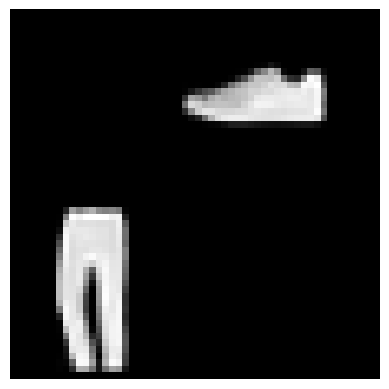

Output Vector: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0] 

Sample 2:
Input Image:


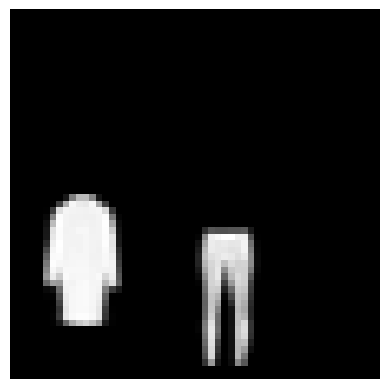

Output Vector: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0] 

Sample 3:
Input Image:


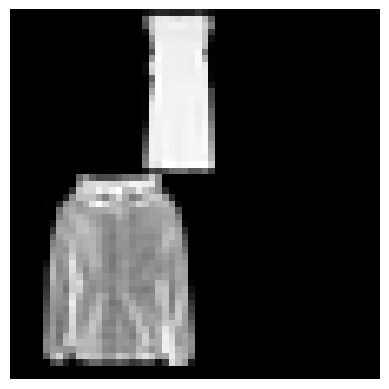

Output Vector: [0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0] 



In [62]:
test_data_scaled = create_samples_with_scaled_images_and_vectors(test_loader, 0.7, 1.3)
test_loader_scaled = create_loader(test_data_scaled)
visualize_samples(test_data_scaled, num_samples=3)

In [58]:
args = SimpleNamespace(batch_size=64, test_batch_size=1000, epochs=1, lr=0.01, momentum=0.5, seed=1, log_interval=100)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define the transformation for the dataset
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load the full FashionMNIST training and test datasets
full_train_dataset = datasets.FashionMNIST(
    os.path.join('.','..','data'), 
    train=True, 
    download=True, 
    transform=transformation
)
full_test_dataset = datasets.FashionMNIST(
    os.path.join('.','..','data'), 
    train=False, 
    download=True, 
    transform=transformation
)

# Combine train and test datasets
full_dataset = torch.utils.data.ConcatDataset([full_train_dataset, full_test_dataset])
torch.manual_seed(args.seed)

# Calculate split sizes
total_size = len(full_dataset)
train_size = int(0.64 * total_size)
val_size = int(0.16 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
test_dataset, val_test_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [val_size, test_size])

# Define data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=True, **kwargs)

# Check proportions
print(f'Train data is {100 * len(test_dataset) / total_size}% of the dataset')
print(f'Val data is {100 * len(val_dataset) / total_size}% of the dataset')
print(f'Test data is {100 * len(test_dataset) / total_size}% of the dataset')
train_data = transform_loader(train_loader)
val_data = transform_loader(val_loader)
test_data = transform_loader(test_loader)

Train data is 20.0% of the dataset
Val data is 16.0% of the dataset
Test data is 20.0% of the dataset


In [56]:
accuracy_rna_scale = []
accuracy_standard_scale = []

In [59]:
accuracy_rna_scale = []
accuracy_standard_scale = []
for scale in scales:
    if scale[0] == 1 and scale[1] == 1:
        test_data_scaled = create_samples_with_scaled_images_and_vectors(test_loader, scale[0]-eps, scale[1]+eps)
        test_loader_scaled = create_loader(test_data_scaled)
    else:
        test_data_scaled = create_samples_with_scaled_images_and_vectors(test_loader, scale[0], scale[1])
        test_loader_scaled = create_loader(test_data_scaled)
    accuracy = calculate_accuracy(model, test_loader_scaled, device)
    accuracy_rna_scale.append(accuracy)
    print(f'Scales: {scale}')
    print(f'Accuracy on the test set RNA: {accuracy:.4f}')
    accuracy = calculate_accuracy_standard(standard_model, test_loader_scaled, device)
    print(f'Accuracy on the test set Standard: {accuracy:.4f}')
    accuracy_standard_scale.append(accuracy)
   

Scales: [1, 1]
Accuracy on the test set RNA: 0.6944
Accuracy on the test set Standard: 0.6667
Scales: [0.9, 1.1]
Accuracy on the test set RNA: 0.4348
Accuracy on the test set Standard: 0.4565
Scales: [0.8, 1.2]
Accuracy on the test set RNA: 0.3654
Accuracy on the test set Standard: 0.4231
Scales: [0.7, 1.3]
Accuracy on the test set RNA: 0.3095
Accuracy on the test set Standard: 0.3333
Scales: [0.6, 1.4]
Accuracy on the test set RNA: 0.1475
Accuracy on the test set Standard: 0.2787
Scales: [0.5, 1.5]
Accuracy on the test set RNA: 0.1860
Accuracy on the test set Standard: 0.2093


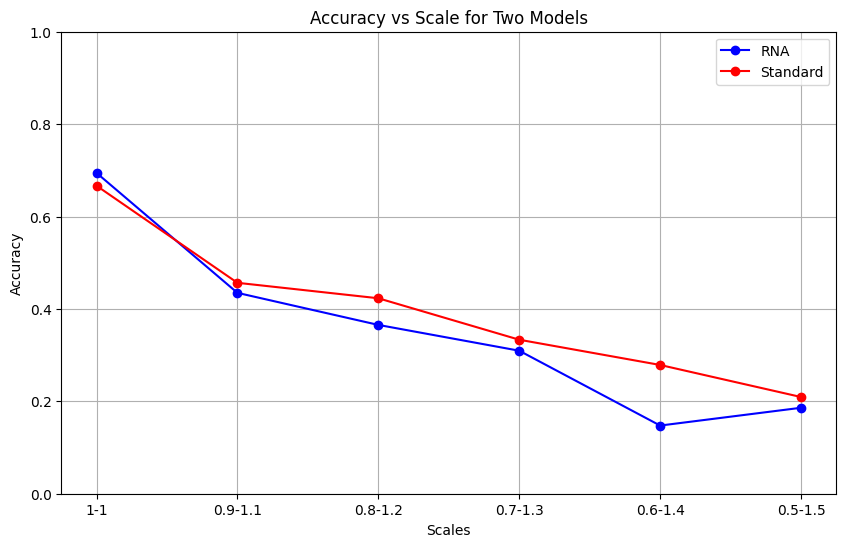

In [60]:
plot_accuracy_comparison(accuracy_rna_scale, accuracy_standard_scale, scales, label1='RNA', label2='Standard', label3='')

### Porównanie historii strat obu modeli

In [45]:
losses_standard = [
    0.002522322523706992,
    0.0015358453313820063,
    0.0012231860052062465,
    0.001008520064642653,
    0.0008428889409905034,
    0.0006989185892494528,
    0.0005518309651025837,
    0.0004201144992839545,
    0.0003003439835655237,
    0.0002018676720867266,
    0.00015022890805474682,
    0.00012207034244056557,
    9.173390772567862e-05,
    9.418948457615832e-05,
    8.781410720725295e-05,
    6.721711401886361e-05,
    6.998202756156908e-05,
    6.859976465810697e-05,
    5.519716710945691e-05,
    4.646069538044425e-05,
    6.072955657730615e-05,
    5.06015090062257e-05,
    4.373626759128716e-05,
    4.605746572289198e-05,
    4.149841850708721e-05,
    2.7939138146158322e-05,
    4.916905396709938e-05,
    3.749886343371145e-05,
    4.058099533649186e-05,
    3.215707906589062e-05,
    3.1188100411928386e-05,
    3.834013898670362e-05,
    2.555579018700119e-05,
    2.9465991221887376e-05,
    3.064981467153822e-05,
    1.956479284753446e-05,
    2.8890846544494968e-05,
    3.057739465335528e-05,
    1.952917226999164e-05,
    2.5633431933686423e-05,
    2.521303300487229e-05,
    2.6130564385746473e-05,
    2.5490118412635964e-05,
    1.8709531515871243e-05,
    2.4624844778194138e-05,
    1.946636567020781e-05,
    1.9323760711082675e-05,
    2.1954170368790724e-05,
    1.660064792494e-05,
    2.3213171703438156e-05
]


In [46]:
losses_rna = [
    0.0042452513730885195,
    0.0023995768701258516,
    0.0017482802551655498,
    0.0012312286421989223,
    0.0007672342051955639,
    0.0004569774588994083,
    0.00027580869585043337,
    0.00019923991933410435,
    0.00015034748108567849,
    0.00013307748284367856,
    0.00010358846661217415,
    0.00011862589963487023,
    8.750827220540357e-05,
    8.129904921836279e-05,
    8.222286550708954e-05,
    7.559496199584309e-05,
    5.961892907150863e-05,
    7.291029473185923e-05,
    4.913585342470534e-05,
    6.04016461231944e-05,
    5.334189897683116e-05,
    5.1928593095250824e-05,
    4.6431357441991034e-05,
    4.734937391954678e-05,
    4.7752676313328785e-05,
    3.7149786115315516e-05,
    4.0221922685341434e-05,
    3.9751488028108335e-05,
    3.6385140633617495e-05,
    3.319450971413776e-05,
    4.033669855016139e-05,
    3.2841371046176605e-05,
    2.7490696416277517e-05,
    3.346390762191882e-05,
    2.8052632284126642e-05,
    3.9283438363726066e-05,
    2.5379559648681343e-05,
    2.3104412422976546e-05,
    3.5600910955310945e-05,
    2.9255571540447128e-05,
    2.2110187798471642e-05,
    3.565918230226371e-05,
    2.17471470336201e-05,
    1.947828027135604e-05,
    2.7593102290153532e-05,
    2.0463054549155124e-05,
    2.5639865103353238e-05,
    2.0403967584973364e-05,
    2.5650598744707385e-05,
    2.4386665989156256e-05
]


In [47]:
def plot_loss_histories(loss_list1, loss_list2, label1='Standard', label2='RNA'):
    epochs = range(1, len(loss_list1) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss_list1, label=label1, marker='o', linestyle='-')
    plt.plot(epochs, loss_list2, label=label2, marker='o', linestyle='-')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log)')
    plt.title('Training Loss History')
    plt.grid(True, which="both", ls="--")
    plt.legend()
    plt.show()

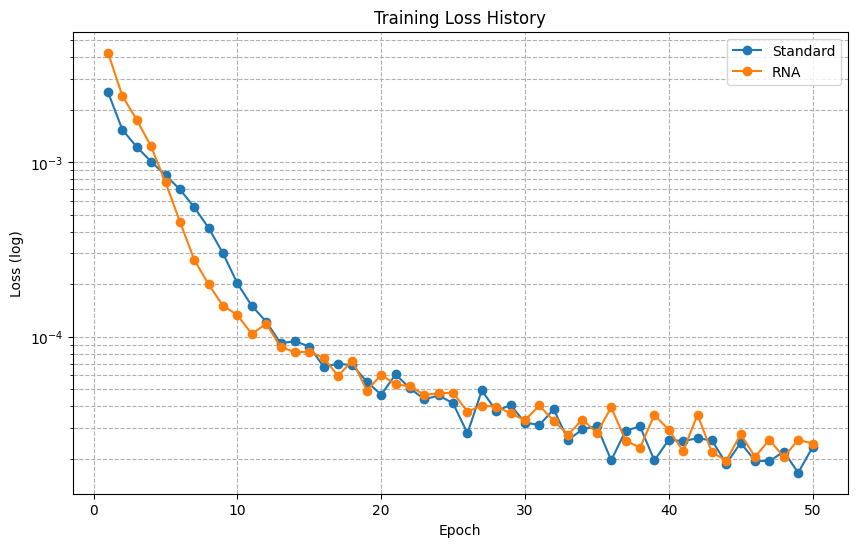

In [48]:
plot_loss_histories(losses_standard, losses_rna)